In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor 
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE

In [4]:
# Load the dataset
train_df = pd.read_csv('hull-tactical-market-prediction/train.csv')
test_df = pd.read_csv('hull-tactical-market-prediction/test.csv')


## preprossing

In [9]:
def remove_nan_greater_than_threshold(df, threshold=0.5):
    """Remove columns with more than threshold proportion of NaN values."""
    return df.loc[:, df.isnull().mean() < threshold]

train_df = remove_nan_greater_than_threshold(train_df)
#train_df.info()
train_df.shape

(8990, 90)

In [ ]:
def

In [ ]:
def categorize_features(df: pd.DataFrame) -> dict:
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ FEATURE CATEGORIZATION")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)


🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 14 features
📊 Macro_Economic: 19 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 11 features
📊 Sentiment: 11 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 90
📈 Total columns in dataset: 90


## clustering analysis


📊 MARKET SEGMENTATION ANALYSIS
🔍 DETERMINING OPTIMAL CLUSTER COUNT:
  k=2: Silhouette Score = 0.1476
  k=3: Silhouette Score = 0.1325
  k=4: Silhouette Score = 0.1501
  k=5: Silhouette Score = 0.1642
  k=6: Silhouette Score = 0.1837
  k=7: Silhouette Score = 0.1758
  k=8: Silhouette Score = 0.1926
  k=9: Silhouette Score = 0.1950
  k=10: Silhouette Score = 0.2032
  k=11: Silhouette Score = 0.2097
  k=12: Silhouette Score = 0.2087
  k=13: Silhouette Score = 0.2059
  k=14: Silhouette Score = 0.2138
  k=15: Silhouette Score = 0.2149
  k=16: Silhouette Score = 0.2114
  k=17: Silhouette Score = 0.2208
  k=18: Silhouette Score = 0.2284
  k=19: Silhouette Score = 0.2144
  k=20: Silhouette Score = 0.2190
  k=21: Silhouette Score = 0.2170
  k=22: Silhouette Score = 0.2161
  k=23: Silhouette Score = 0.2125
  k=24: Silhouette Score = 0.2103

Optimal number of clusters: 18

📈 CLUSTER CHARACTERISTICS:

Cluster 0 (372 samples):
  Average Return: 0.000480
  Volatility: 0.006936
  Sharpe Ratio: 0.069

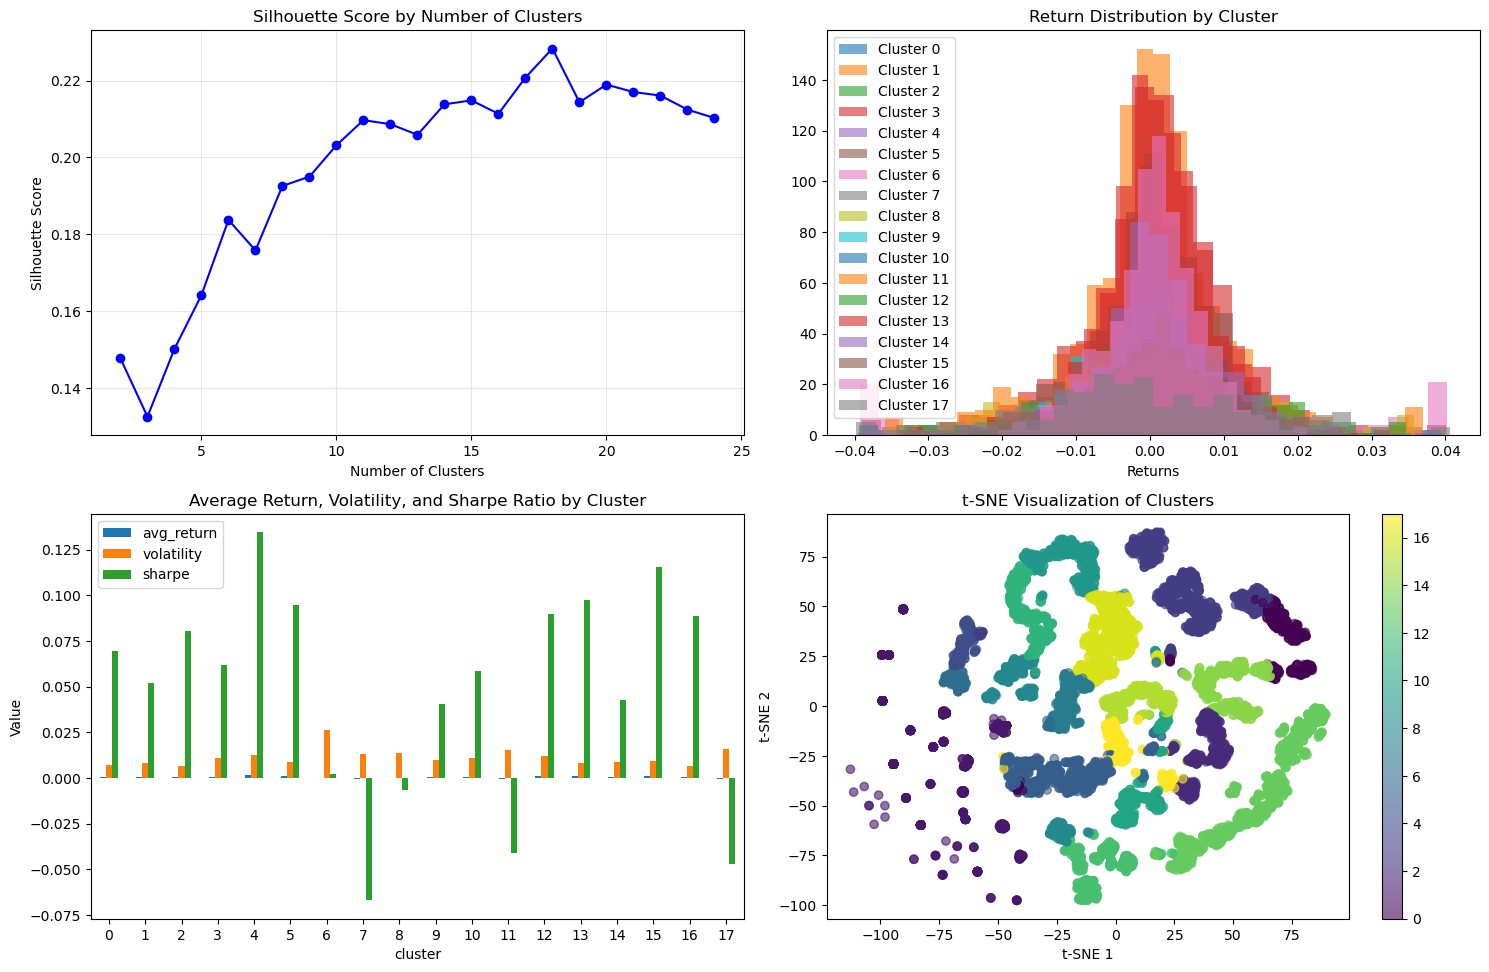

In [24]:

# 5. CLUSTERING AND SEGMENTATION ANALYSIS
def perform_market_segmentation(df, feature_categories, n_clusters=5):
    """
    Perform market regime clustering and segmentation analysis
    """
    print("\n📊 MARKET SEGMENTATION ANALYSIS")
    print("="*60)
    
    # --------------------------- data preprocessing --------------------------
    # Prepare feature matrix for clustering
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features) #[:5])  # Top 5 from each category
    
    #if len(feature_cols) > 30:
    #    feature_cols = feature_cols[:30]  # Limit features
    
    X = df[feature_cols].fillna(0)

    #print(X.info())
    #print(type(X))
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # ------------------------- clustering ---------------------------------
    # Determine optimal number of clusters
    print("🔍 DETERMINING OPTIMAL CLUSTER COUNT:")
    
    silhouette_scores = []
    k_range = range(2, min(25, len(X)//100))  # Reasonable range
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"  k={k}: Silhouette Score = {silhouette_avg:.4f}")
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k}")
    
    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Analyze cluster characteristics
    print(f"\n📈 CLUSTER CHARACTERISTICS:")
    
    cluster_stats = []
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        if 'forward_returns' in cluster_data.columns:
            returns = cluster_data['forward_returns'].dropna()
            stats_dict = {
                'cluster': cluster_id,
                'size': len(cluster_data),
                'avg_return': returns.mean(),
                'volatility': returns.std(),
                'sharpe': returns.mean() / returns.std() if returns.std() > 0 else 0,
                'min_return': returns.min(),
                'max_return': returns.max()
            }
            cluster_stats.append(stats_dict)
            
            print(f"\nCluster {cluster_id} ({len(cluster_data)} samples):")
            print(f"  Average Return: {stats_dict['avg_return']:.6f}")
            print(f"  Volatility: {stats_dict['volatility']:.6f}")
            print(f"  Sharpe Ratio: {stats_dict['sharpe']:.4f}")
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Silhouette scores
    axes[0, 0].plot(k_range, silhouette_scores, 'bo-')
    axes[0, 0].set_title('Silhouette Score by Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Cluster returns distribution
    if 'forward_returns' in df_clustered.columns:
        for cluster_id in range(optimal_k):
            cluster_returns = df_clustered[df_clustered['cluster'] == cluster_id]['forward_returns'].dropna()
            axes[0, 1].hist(cluster_returns, alpha=0.6, label=f'Cluster {cluster_id}', bins=30)
        axes[0, 1].set_title('Return Distribution by Cluster')
        axes[0, 1].set_xlabel('Returns')
        axes[0, 1].legend()
    
    # Cluster characteristics
    if cluster_stats:
        cluster_stats_df.set_index('cluster')[['avg_return', 'volatility', 'sharpe']].plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Average Return, Volatility, and Sharpe Ratio by Cluster')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].tick_params(axis='x', rotation=0)
    
    # t-SNE visualization (if computationally feasible)
    if len(X_scaled) <= 10000:  # Limit for t-SNE
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
            X_tsne = tsne.fit_transform(X_scaled)
            
            scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            axes[1, 1].set_title('t-SNE Visualization of Clusters')
            axes[1, 1].set_xlabel('t-SNE 1')
            axes[1, 1].set_ylabel('t-SNE 2')
            plt.colorbar(scatter, ax=axes[1, 1])
        except:
            axes[1, 1].text(0.5, 0.5, 't-SNE visualization\nnot available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cluster_labels': cluster_labels,
        'cluster_stats': cluster_stats_df,
        'optimal_k': optimal_k,
        'silhouette_scores': silhouette_scores
    }
    
segmentation_results = perform_market_segmentation(train_df, feature_categories, n_clusters=5)


### result interpretation
the Silhouette Scores are noticeably better, peaking at 0.2284 (for k=18). While still in the "weak structure" category, they are much closer to the "reasonable structure" threshold of 0.25. This suggests your feature selection or preparation for this clustering run was more effective.

#### Analysis of Cluster Characteristics 📈
Your new set of 18 clusters shows a clear separation between different types of market behavior, which is exactly what you want for a predictive feature.

1. The "Bearish / Fear" Regimes 📉
You have clearly isolated several high-risk periods. A model could learn to be highly defensive when it identifies these clusters.

    Cluster 7: A strong "downturn" regime with the most negative average return (-0.000890) and significant volatility.

    Cluster 17 & 11: Also clear "risk-off" signals with strongly negative returns and high volatility.

    Cluster 6: This is a classic "high-volatility crash" regime. Its average return is near zero, but its volatility is enormous (0.026457), making it extremely risky.

    Cluster 8: A milder "drift down" market with slightly negative returns.

2. The "Strong Bullish" Regimes 🚀
You have found clusters representing periods of high growth, where an aggressive strategy would pay off.

    Cluster 4: This is your new "high-risk, high-reward" regime. It has the highest average return (0.001665) by a wide margin. Its Sharpe Ratio is also the best (0.1345).

    Cluster 12 & 15: These represent strong, positive market periods with excellent returns and good risk-adjusted performance (Sharpe Ratios of 0.0900 and 0.1156).

3. The "Stable Growth" Regimes 🌱
    These clusters represent calm, positive markets ideal for steady, low-risk investment.

    Cluster 2 & 16: These clusters have very low volatility (around 0.0066) combined with solid positive returns, leading to good Sharpe Ratios.

    Cluster 13: A large, stable cluster with good returns and a high Sharpe Ratio (0.0972).

#### Verdict and Recommendations ✅
This cluster feature is very plausible and potentially even more powerful than your last iteration due to the better statistical separation (higher Silhouette Score) and the clear identification of extreme risk/reward regimes.

Your next steps remain the same, but you can proceed with more confidence:

Test This Feature: Prioritize this new 18-cluster feature. Add it to your model and run it through your A/B testing framework to see if it improves the out-of-sample Sharpe Ratio and equity curve.

Consider Consolidation: As before, many clusters are "neutral" and similar (e.g., Clusters 0, 1, 3, 5, 9, 10, 14). If you want to create a simpler, more robust feature, you could manually group the 18 clusters into 4-6 "meta-clusters" (e.g., High_Fear, High_Reward, Stable_Growth, Neutral).

Compare Both Versions: You now have two promising cluster features (the 22-cluster version and this 18-cluster version). You can run them both through your evaluation script to see which one provides a greater performance boost to the final model.



### Cluster Assignments Over Time analysis

   date_id  cluster
0        0        1
1        1        1
2        2        1
3        3        1
4        4        1


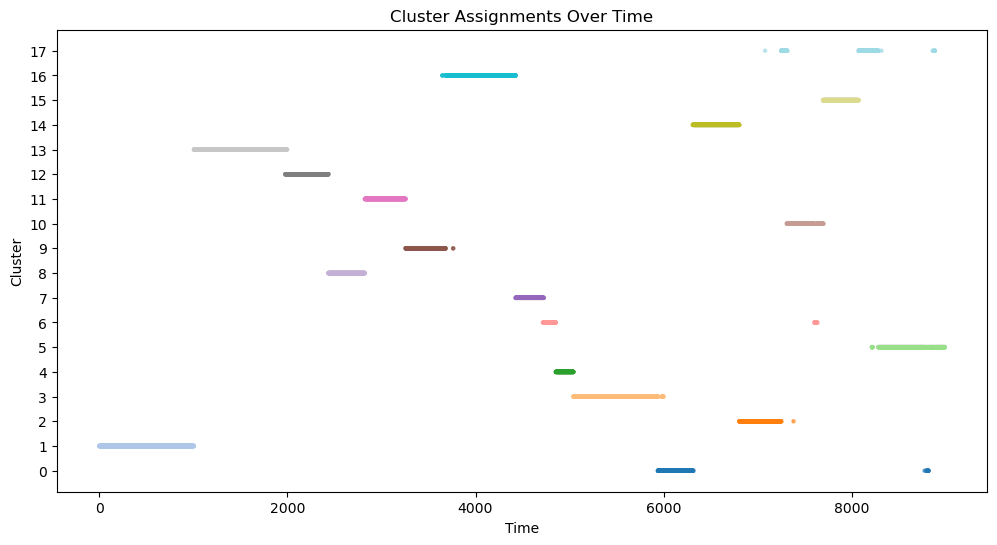

In [32]:
# visualize what clusters appear on what time

train_df['cluster'] = segmentation_results['cluster_labels']
optimal_k = segmentation_results['optimal_k']

print(train_df[['date_id', 'cluster']].head())

plt.figure(figsize=(12, 6))
plt.scatter(train_df['date_id'], train_df['cluster'], c=train_df['cluster'], cmap='tab20', alpha=0.6, s=5)
plt.title('Cluster Assignments Over Time')
plt.xlabel('Time')
plt.ylabel('Cluster')
plt.yticks(range(optimal_k))
plt.show()


#### results
The same cluster assignments usually land in one consecutive period over the whole time, and does not appear again.  
Based on this plot, this is not a useful clustering for a predictive model.

Your observation is exactly right and it points to a critical issue. The plot shows that your clustering algorithm has not identified recurring market regimes (like "high-volatility" or "calm growth"). Instead, it has identified distinct historical market eras or structural breaks.

1. What This Plot Reveals  
The chart shows that each cluster ID corresponds to a specific, non-repeating period of time. For example, the market is in Cluster 13 for a long stretch, then it permanently moves to Cluster 12, then to Cluster 8, and so on.  
A useful "market regime" feature would be one that the market can enter, exit, and re-enter later. For instance, a "crash" regime (let's say Cluster 7) should have appeared during the 2008 crisis and also during the 2020 COVID crash. Your plot clearly shows this is not happening.

2. The Likely Cause: Time-Trending Features  
This pattern is a classic symptom of using non-stationary or time-trending features in your clustering algorithm.  
K-Means groups data points that are "close" to each other in the feature space. If your features have a strong trend over time (e.g., they consistently increase), data points that are close in time will naturally be grouped together.  
A simple analogy is clustering people by their height from age 2 to 18. You would get clusters for "toddlers," "children," and "teenagers." A 17-year-old will never be in the "toddler" cluster because the feature (height) is strongly correlated with time (age). Your model is doing the same thing—it's clustering by "market age."

    Features that cause this include:

    - Absolute price levels of an index (e.g., the S&P 500 price).

    - Cumulative indicators or running sums.

    - Macroeconomic data that trends over decades (like GDP or national debt).

3. Why This Is a Problem for Prediction  
Your model has learned to identify eras, not states. For a predictive model, this is not useful because:  
The Future is a New Era: The model will see future data as part of the most recent era (e.g., Cluster 17 in your chart). It has no way of recognizing that a future market crash might be functionally identical to a crash from a past era (e.g., Cluster 8).  
No Recurring Patterns: The model can't learn that "when we enter Cluster X, Y tends to happen," because Cluster X only ever happened once.

4. How to Fix It: Use Stationary Features ✅  
To create a useful regime feature, you must perform clustering on features that are stationary or cyclical. These features measure relative changes, not absolute levels.  
Here are the changes you should make to the set of features you use for clustering:  
    - Use Returns, Not Prices: Instead of the S&P 500 price level, use its daily or weekly percentage change (return).
    - Use Spreads, Not Levels: For interest rates, use the spread between two rates (e.g., 10-year minus 2-year yield). Spreads tend to revert to a mean.
    - Use Oscillators: Use technical indicators that oscillate around a central line, like the RSI (Relative Strength Index) or Stochastic Oscillator.

Detrend Your Data: For any feature that still has a trend, use its first difference (today's value minus yesterday's value) or the percentage change from a long-term moving average.

### Detrending data

## Model comparison

In [ ]:
# --- 步骤 1 & 2: 保持不变 ---
log1 = True
log2 = True
print("数据和函数已加载。")
base_model_descirption = "75 top features 0 imputer"
new_model_descirption = "75 top features KNN-7 imputer"
ID = 9
date = "2025/10/11"

IMPUTER_PARAMETERS = {
    'n_neighbors': 7,             
    'weights': 'uniform',         # 可以是 'uniform' 或 'distance'
    'missing_values': np.nan      # 告诉 Imputer 哪些值是缺失的
}
KNN_IMPUTER = KNNImputer(**IMPUTER_PARAMETERS)

# 定义要比较的两个模型
model_base = Pipeline([
    ('feature_creator', feature_creator2),
    #('imputer', SimpleImputer(strategy='median')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('regressor', CatBoostRegressor(**Best_parameters2, verbose=0, random_seed=42))
])
model_new = Pipeline([
    ('feature_creator', feature_creator2),
    #('imputer', SimpleImputer(strategy='median')),
    ('knn_imputer', KNN_IMPUTER), 
    ('regressor', CatBoostRegressor(**Best_parameters2, verbose=0, random_seed=42))
])
print(f"实验ID：{ID}, 时间：{date}")
print(f"\n基础模型 ({base_model_descirption}) 和新模型 ({new_model_descirption}) 已定义。")

# --- 步骤 3: 执行前向展开分析 (增加预测值收集) ---

print("\n开始执行前向展开分析...")

n_samples = len(X)
initial_train_size = int(n_samples * 0.5)
test_size = int(n_samples * 0.1)

# 初始化列表以存储分数和预测结果
base_model_sharpe_scores, new_model_sharpe_scores = [], []
base_model_r2_scores, new_model_r2_scores = [], []
all_test_indices, all_y_true, all_base_preds, all_new_preds = [], [], [], []

train_start_index = 0
train_end_index = initial_train_size
test_end_index = train_end_index + test_size

while test_end_index <= n_samples:
    print(f"训练周期: index {train_start_index} to {train_end_index-1} | "
          f"测试周期: index {train_end_index} to {test_end_index-1}")

    X_train, y_train = X.iloc[train_start_index:train_end_index], y.iloc[train_start_index:train_end_index]
    X_test, y_test = X.iloc[train_end_index:test_end_index], y.iloc[train_end_index:test_end_index]

    model_base.fit(X_train, y_train)
    model_new.fit(X_train, y_train)

    preds_base = model_base.predict(X_test)
    preds_new = model_new.predict(X_test)
    
    # 收集分数
    base_model_sharpe_scores.append(ad_sharpe_ratio_scorer(model_base, X_test, y_test))
    new_model_sharpe_scores.append(ad_sharpe_ratio_scorer(model_new, X_test, y_test))
    base_model_r2_scores.append(r2_score(y_test, preds_base))
    new_model_r2_scores.append(r2_score(y_test, preds_new))
    
    # <--- 新增：收集用于绘图的数据 --- >
    all_test_indices.append(y_test.index)
    all_y_true.append(y_test.values)
    all_base_preds.append(preds_base)
    all_new_preds.append(preds_new)
    
    train_start_index += test_size
    train_end_index += test_size
    test_end_index += test_size

print("\n前向展开分析完成。")
print(f"基础模型在各周期的夏普率: {[f'{s:.4f}' for s in base_model_sharpe_scores]}， 平均日夏普率：{np.mean(base_model_sharpe_scores)}")
print(f"新模型在各周期的夏普率:   {[f'{s:.4f}' for s in new_model_sharpe_scores]}， 平均日夏普率：{np.mean(new_model_sharpe_scores)}")
print("-" * 50)
print(f"基础模型在各周期的 R²: {[f'{s:.4f}' for s in base_model_r2_scores]}， 平均R2：{np.mean(base_model_r2_scores)}")
print(f"新模型在各周期的 R²:   {[f'{s:.4f}' for s in new_model_r2_scores]}， 平均R2：{np.mean(new_model_r2_scores)}")

# --- 步骤 4: t检验 (保持不变) ---
'''
print("\n--- 执行配对t检验 (基于夏普率) ---")
if len(base_model_sharpe_scores) > 2:
    t_stat_sharpe, p_val_sharpe = stats.ttest_rel(new_model_sharpe_scores, base_model_sharpe_scores, alternative='greater')
    print(f"T-statistic: {t_stat_sharpe:.4f}")
    print(f"P-value: {p_val_sharpe:.4f}")
    alpha = 0.05
    if p_val_sharpe < alpha:
        print("结论: 在夏普率方面，新模型(中位数填充)的提升在统计上是显著的。")
    else:
        print("结论: 在夏普率方面，新模型(中位数填充)的提升不具备统计显著性。")
else:
    print("测试周期太少，无法进行有效的t检验。")

# --- 4b. 针对R²的t检验 ---
print("\n--- 执行配对t检验 (基于 R²) ---")
if len(base_model_r2_scores) > 2:
    t_stat_r2, p_val_r2 = stats.ttest_rel(new_model_r2_scores, base_model_r2_scores, alternative='greater')
    print(f"T-statistic: {t_stat_r2:.4f}")
    print(f"P-value: {p_val_r2:.4f}")
    alpha = 0.05
    if p_val_r2 < alpha:
        print("结论: 在 R² 方面，新模型(中位数填充)的预测准确性提升在统计上是显著的。")
    else:
        print("结论: 在 R² 方面，新模型(中位数填充)的预测准确性提升不具备统计显著性。")
else:
    print("测试周期太少，无法进行有效的t检验。")
'''
# --- 步骤 5: 拼接数据并绘制总体拟合图 ---

print("\n--- 正在生成总体拟合图 ---")

# 1. 将所有周期的测试数据拼接成一个连续的序列
if all_test_indices:
    combined_indices = np.concatenate(all_test_indices)
    combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
    combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds (fill 0)")
    combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds (median)")

    # 2. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 3. 绘制真实值和两个模型的预测值
    plt.plot(combined_y_true, label='Actual Target (True Returns)', color='black', linewidth=2, alpha=0.7)
    plt.plot(combined_base_preds, label=f'Base Model Predictions ({base_model_descirption})', color='orangered', linewidth=1, alpha=0.8)
    plt.plot(combined_new_preds, label=f'New Model Predictions ({new_model_descirption})', color='dodgerblue', linewidth=1, alpha=0.8)

    # 4. 添加图表元素
    plt.title('Overall Model Fit: Out-of-Sample Predictions vs. Actual Target', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel(f'{TARGET}', fontsize=12)
    plt.legend(fontsize=10)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1) # 添加0线作为参考
    
    # 5. 显示图表
    plt.show()
else:
    print("没有可用于绘图的预测数据。")
    
print("\n--- 正在生成累积收益拟合图 (权益曲线) ---")

if all_test_indices:
    # 1. 拼接数据 (如果尚未拼接)
    if 'combined_y_true' not in locals():
        combined_indices = np.concatenate(all_test_indices)
        combined_y_true = pd.Series(np.concatenate(all_y_true), index=combined_indices, name="Actual Target")
        combined_base_preds = pd.Series(np.concatenate(all_base_preds), index=combined_indices, name="Base Model Preds")
        combined_new_preds = pd.Series(np.concatenate(all_new_preds), index=combined_indices, name="New Model Preds")

    # 2. 计算每个周期的策略收益
    # 基准策略: 买入并持有市场 (收益就是真实的目标值)
    benchmark_returns = combined_y_true
    
    # 基础模型策略收益 (根据 sharpe_ratio_scorer 的逻辑)
    base_positions = np.where(combined_base_preds > 0, combined_base_preds*1000, 0)
    base_positions = np.clip(base_positions, 0, 2)
    base_strategy_returns = pd.Series(base_positions*benchmark_returns.values, index=benchmark_returns.index)
    
    # 新模型策略收益
    new_positions = np.where(combined_new_preds > 0, combined_new_preds*1000, 0)
    new_positions = np.clip(new_positions, 0, 2)
    new_strategy_returns = pd.Series(new_positions*benchmark_returns.values, index=benchmark_returns.index)

    # 3. 计算累积收益 (权益曲线)
    cumulative_benchmark = benchmark_returns.cumsum()
    cumulative_base_strategy = base_strategy_returns.cumsum()
    cumulative_new_strategy = new_strategy_returns.cumsum()

    # 4. 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(20, 8))

    # 5. 绘制三条累积收益曲线
    plt.plot(cumulative_benchmark, label='Benchmark (Buy & Hold Market)', color='black', linewidth=2, alpha=0.7)
    plt.plot(cumulative_base_strategy, label=f'Base Model Strategy ({base_model_descirption})', color='orangered', linewidth=2)
    plt.plot(cumulative_new_strategy, label=f'New Model Strategy ({new_model_descirption})', color='dodgerblue', linewidth=2)
    
    # 6. 添加图表元素
    plt.title('Cumulative Performance: Model Strategies vs. Benchmark', fontsize=16)
    plt.xlabel('Trading Day Index', fontsize=12)
    plt.ylabel('Cumulative Excess Returns', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # 7. 显示图表
    plt.show()